In [1]:
# !python -m spacy download nl_core_news_sm

In [2]:
import pandas as pd
import numpy as np
import string
import re

from datasets import Dataset, load_metric
from transformers import DataCollatorForTokenClassification, pipeline, AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, TrainerCallback

import torch

import spacy
from spacy import displacy

import os
from datetime import datetime
import json

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pickle
import math

C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from loss_functions import DiceLoss, MoMLoss

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# Load leeuwarde courant Excel file into a DataFrame
df_lc = pd.read_excel('dataset/data/manullay_check_partially_matched_titles.xlsx', engine='openpyxl')

In [71]:
# Load trouw and het parool annotated book review file into a DataFrame
df_trouw_parool = pd.read_csv('dataset/data/trouw_and_parool_annotated_book_titles.csv')

In [7]:
def remove_extra_spaces(text):
    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [8]:
df_lc['content'] = df_lc['content'].apply(remove_extra_spaces)
df_lc['title1'] = df_lc['title1'].apply(remove_extra_spaces)
df_lc['title4'] = df_lc['title4'].apply(remove_extra_spaces)

In [9]:
def remove_punctuation(input_string):
    # Adding old Dutch quotation marks to the punctuation list
    extended_punctuation = string.punctuation + '„“'
    # Create a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', extended_punctuation)
    # Translate the input string using the translation table
    return input_string.translate(translator)

In [10]:
# First, filter rows where 'manually_removed' is 1 and get unique 'content' values in these rows
content_removed = df_lc[df_lc['manually_removed'] == 1]['content'].unique()

# Now, filter out these 'content' values from the main DataFrame and find unique 'content' not removed
df_lc_clean = df_lc[~df_lc['content'].isin(content_removed)]

## Preprare for training

In [11]:
# model_checkpoint = "distilbert-base-uncased"

model_checkpoint = "Babelscape/wikineural-multilingual-ner"   # BEST F1 0.65

# TO USE:
# model_checkpoint = "FacebookAI/xlm-roberta-large-finetuned-conll03-english"
# model_checkpoint = "pdelobelle/robbert-v2-dutch-ner"
# model_checkpoint = "GroNLP/bert-base-dutch-cased"   # BEST F1 0.59
# model_checkpoint = "pdelobelle/robbert-v2-dutch-base"

In [12]:
label_list = ['O', 'I']

In [13]:
def find_sentence_in_text(full_text, sentence):
    start_index = full_text.find(sentence)
    if start_index == -1:
        raise ValueError("Sentence not found in text.")
    end_index = start_index + len(sentence)
    return start_index, end_index


def create_mask_for_sentence(full_text, sentence, nlp, force_lower_case=False):
    # Use the already loaded nlp model to process the text
    doc = nlp(full_text)
    start_index, end_index = find_sentence_in_text(full_text.lower(), sentence.lower())
    if start_index is None:
        return None, None
    if force_lower_case:
        tokens = [token.text.lower() for token in doc]
    else:
        tokens = [token.text for token in doc]
    mask = [0] * len(doc)

    for i, token in enumerate(doc):
        token_end_idx = token.idx + len(token.text)
        if token.idx <= end_index and token_end_idx >= start_index:
            mask[i] = 1

    return tokens, mask


def create_data_set(samples, df, nlp, remove_punc=False, force_lower_case=False):
    data = []
    for sample in tqdm(samples):
        unique_content_df = df[df['content'] == sample]
        masks = []

        if remove_punc:
            review = remove_punctuation(sample)
        else:
            review = sample
        
        for _, row in unique_content_df.iterrows():
            if remove_punc:
                book = remove_punctuation(row['title4'])
            else:
                book = row['title4']
                
            tokens, mask = create_mask_for_sentence(full_text=review, sentence=book, nlp=nlp, force_lower_case=force_lower_case) 
            if mask is not None:
                masks.append(mask)

        if masks:
            combined_mask = np.bitwise_or.reduce(np.array(masks), axis=0)
            data.append({"tokens": tokens, "ner_tags": combined_mask})

    return data

def trouw_parool_create_dataset(df, nlp, remove_punc=False, force_lower_case=False):
    data = []
    
    for sample in tqdm(df['text'].unique()):
        unique_content_df = df[df['text'] == sample]
        masks = []

        if remove_punc:
            review = remove_punctuation(sample)
        else:
            review = sample

        
        doc = nlp(review)
        if force_lower_case:
            tokens = [token.text.lower() for token in doc]
        else:
            tokens = [token.text for token in doc]

        
        for _, row in unique_content_df.iterrows():
            start_index, end_index = row['start_index'], row['end_index']

            mask = [0] * len(doc)
            
            for i, token in enumerate(doc):
                token_end_idx = token.idx + len(token.text)
                if token.idx <= end_index and token_end_idx >= start_index:
                    mask[i] = 1
                
            masks.append(mask)

        if masks:
            combined_mask = np.bitwise_or.reduce(np.array(masks), axis=0)
            data.append({"tokens": tokens, "ner_tags": combined_mask})
            
    return data

In [14]:
nlp = spacy.load("nl_core_news_sm")

In [15]:
remove_punc = False
force_lower_case = False

In [16]:
lc_train_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/data/lc_train_dataset.pkl'
lc_val_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/data/lc_val_dataset.pkl'
lc_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/data/lc_test_dataset.pkl'

trouw_parool_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/data/trouw_parool_test_dataset.pkl'

In [17]:
# Function to save dataset to file
def save_dataset(dataset, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure the directory exists
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)

# Function to load dataset from file
def load_dataset(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [18]:
# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the unique samples
samples = df_lc_clean['content'].unique()
np.random.shuffle(samples)

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute the split indices
train_end = int(len(samples) * train_ratio)
val_end = train_end + int(len(samples) * val_ratio)

# Split the data
lc_train_samples = samples[:train_end]
lc_val_samples = samples[train_end:val_end]
lc_test_samples = samples[val_end:]


if os.path.exists(lc_train_filename) and os.path.exists(lc_val_filename) and os.path.exists(lc_test_filename):
    print("Loading training, validation, and test datasets....")
    lc_train_dataset = load_dataset(lc_train_filename)
    lc_val_dataset = load_dataset(lc_val_filename)
    lc_test_dataset = load_dataset(lc_test_filename)
else:
    print("Creating training, validation, and test datasets....")
    # Create dataset
    lc_train_dataset = Dataset.from_list(create_data_set(samples=lc_train_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_val_dataset = Dataset.from_list(create_data_set(samples=lc_val_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_test_dataset = Dataset.from_list(create_data_set(samples=lc_test_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))

    # Save dataset, so we don't have to create it everytime again
    save_dataset(lc_train_dataset, lc_train_filename)
    save_dataset(lc_val_dataset, lc_val_filename)
    save_dataset(lc_test_dataset, lc_test_filename)

print("Done...")

Loading training, validation, and test datasets....
Done...


In [19]:
lc_train_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 8774
})

In [20]:
lc_val_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1880
})

In [21]:
lc_test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1881
})

### Create Trouw & Parool TEST dataset

In [22]:
if os.path.exists(trouw_parool_test_filename):
    print("Loading trouw parool test dataset....")
    trouw_parool_test_dataset = load_dataset(trouw_parool_test_filename)
else:
    print("Creating trouw parool test dataset....")
    trouw_parool_test_dataset = Dataset.from_list(trouw_parool_create_dataset(df=df_trouw_parool, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    
    # Save dataset, so we don't have to create it everytime again
    save_dataset(trouw_parool_test_dataset, trouw_parool_test_filename)

Loading trouw parool test dataset....


In [23]:
trouw_parool_test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 308
})

## Tokenize text representation and align subtokens with labels

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [25]:
label_all_tokens = True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [26]:
lc_tokenized_dataset_train = lc_train_dataset.map(tokenize_and_align_labels, batched=True)
lc_tokenized_dataset_val = lc_val_dataset.map(tokenize_and_align_labels, batched=True)
lc_tokenized_dataset_test = lc_test_dataset.map(tokenize_and_align_labels, batched=True)

trouw_parool_tokenized_dataset_test = trouw_parool_test_dataset.map(tokenize_and_align_labels, batched=True)


lc_tokenized_dataset_train

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:00<00:00, 447.91 examples/s]


Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 8774
})

In [27]:
def compute_metrics(p): 
    logits, labels = p
    predictions = np.argmax(logits, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]

    total_count_O = 0
    total_count_I = 0
    for pred in true_predictions:
        total_count_O = total_count_O + sum(s.count("O") for s in pred)
        total_count_I = total_count_I + sum(s.count("I") for s in pred)
        
    # Flatten the lists to enable macro F1 calculation using sklearn
    flat_predictions = [label for sublist in true_predictions for label in sublist]
    flat_labels = [label for sublist in true_labels for label in sublist]

    # Calculate the macro F1 score
    macro_f1 = f1_score(y_true=flat_labels, y_pred=flat_predictions, average='macro')
    macro_recall = recall_score(y_true=flat_labels, y_pred=flat_predictions, average='macro')
    macro_precision = precision_score(y_true=flat_labels, y_pred=flat_predictions, average='macro')
    accuracy = accuracy_score(y_true=flat_labels, y_pred=flat_predictions)

    
    return {
        "total_count_O": total_count_O,
        "total_count_I": total_count_I,
        "macro_f1": macro_f1,
        "recall": macro_recall,
        "precision": macro_precision,
        "accuracy": accuracy
    }

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [30]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, num_labels=2, ignore_mismatched_sizes=True
)
model.config.id2label = {0: 'NO_BOOK', 1: 'BOOK'}

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Babelscape/wikineural-multilingual-ner and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
class MyTrainer(Trainer):
    """
    A custom trainer class that extends the Trainer class to provide specialized loss computation
    and enhanced logging capabilities specific to the model's training process.

    This trainer overrides the compute_loss method to utilize a custom loss function, referred to here
    as MoMLoss, which is applied to the logits produced by the model. Additionally, this class modifies
    the logging functionality to record the loss at each training step along with its corresponding epoch,
    facilitating detailed tracking and analysis of the model's training progression.

    Attributes:
        loss_history (list of dict): Keeps a record of loss values and their corresponding epoch numbers.
                                     This enables easy tracking and visualization of the training loss over time.

    Methods:
        compute_loss(model, inputs, return_outputs=False): Computes the loss using MoMLoss based on the outputs
                                                           from the model and the provided labels. It can optionally
                                                           return the model outputs alongside the loss.

        log(logs): Extends the base Trainer's log method to also append the loss and epoch to the loss_history for
                   historical tracking. This is particularly useful for visualizing the training progression post-training.

    Example:
        class MyModel(nn.Module):
            # model definition

        trainer = MyTrainer(MyModel(), other_args)
        trainer.train()
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = []
    
    def compute_loss(self, model, inputs, return_outputs=False):
        """ MoM LOSS """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # Assuming logits are stored in outputs.logits

        # Compute loss using DiceLoss
        loss_fn = MoMLoss()
        loss = loss_fn(logits, labels)

        # Store loss for logging
        self.log({"loss": loss.item(), "epoch": self.state.epoch})

        return (loss, outputs) if return_outputs else loss

    def log(self, logs):
        super().log(logs)
        # Save the training loss for each log step
        if self.model.training:
            if 'loss' in logs:
                self.loss_history.append({"epoch": logs.get("epoch", 0), "loss": logs["loss"]})

In [32]:
def visualise_training_history(trainer):
    """
    Generates a plot showing smoothed training loss, training F1 score, and evaluation F1 score over epochs. 
    The training loss is smoothed to take an average over an epoch, as the training loss is calculated for each batch indiviually per epoch (thus multiple times per epoch).

    Args:
        trainer: A training instance containing loss_history and state.log_history.
        window_size: The size of the moving average window for smoothing the loss.

    Returns:
        fig: A matplotlib figure object with the plot.
    """
    epoch_losses = {}
    for point in trainer.loss_history:
        # Use ceiling to round the epoch to the next highest whole number
        epoch = math.ceil(point['epoch'])
        loss = point['loss']
        if epoch not in epoch_losses:
            epoch_losses[epoch] = []
        epoch_losses[epoch].append(loss)
    
    # Calculate average loss per epoch
    epochs = sorted(epoch_losses.keys())
    avg_losses = [np.mean(epoch_losses[epoch]) for epoch in epochs]
    
    eval_epochs = [math.ceil(entry['epoch']) for entry in trainer.state.log_history if 'eval_macro_f1' in entry]
    eval_f1_scores = [entry['eval_macro_f1'] for entry in trainer.state.log_history if 'eval_macro_f1' in entry]

    # Create the plot for smoothed training loss
    fig, ax1 = plt.subplots(figsize=(10, 6))
    line1, = ax1.plot(epochs, avg_losses, marker='o', color='b', label='Training Loss (MoM)')
    ax1.set_title("Training Loss and Evaludation F1 Score vs. Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Loss")
    ax1.grid(True)
    
    # Create secondary y-axis for F1 scores
    ax2 = ax1.twinx()
    line2, = ax2.plot(eval_epochs, eval_f1_scores, marker='s', color='r', label='Evaluation F1 Score')
    ax2.set_ylabel('F1 Score')

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    return fig

In [33]:
training_args = TrainingArguments(
    output_dir="test_model",
    learning_rate=2.5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    greater_is_better=True,
    fp16=True,  # Enable mixed precision training (trains faster and decreases gpu memory)
    dataloader_pin_memory=True,  # Pin memory in dataloader (trains faster and decreases gpu memory)
    push_to_hub=False

)

# Create a custom Trainer instance
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=lc_tokenized_dataset_train,
    eval_dataset=lc_tokenized_dataset_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [34]:
# Clear up RAM space
del df_lc
del df_trouw_parool
del lc_train_dataset
del lc_val_dataset

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Total Count O,Total Count I,Macro F1,Recall,Precision,Accuracy
1,0.165506,0.289137,818592,51005,0.757681,0.948059,0.686769,0.961789


TrainOutput(global_step=549, training_loss=0.3280911888581156, metrics={'train_runtime': 323.3661, 'train_samples_per_second': 27.133, 'train_steps_per_second': 1.698, 'total_flos': 2292617743601664.0, 'train_loss': 0.3280911888581156, 'epoch': 1.0})

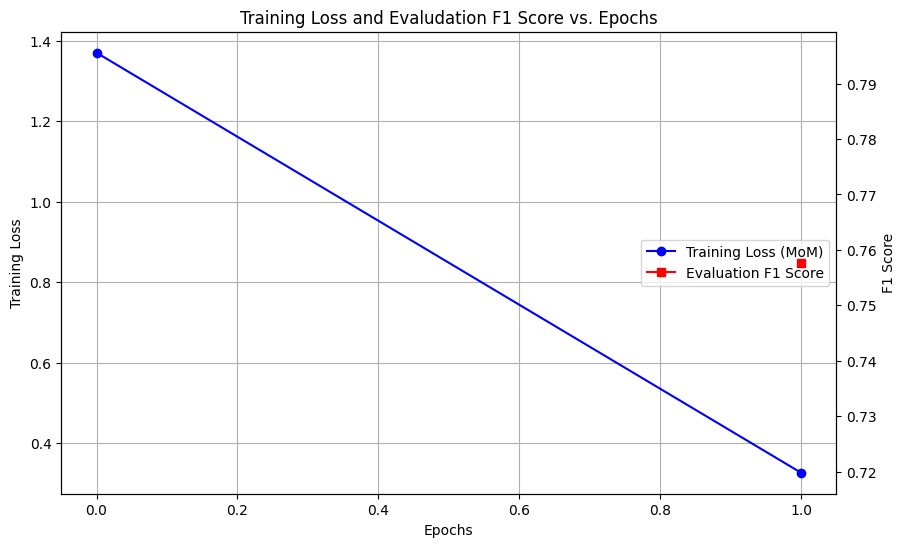

In [36]:
fig = visualise_training_history(trainer)

### Evaluate models on test datasets

In [37]:
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [38]:
trainer.evaluate(eval_dataset=lc_tokenized_dataset_test)

{'eval_loss': 0.26501917839050293,
 'eval_total_count_O': 814900,
 'eval_total_count_I': 50553,
 'eval_macro_f1': 0.7585648594921586,
 'eval_recall': 0.9481782879660945,
 'eval_precision': 0.6875754503455375,
 'eval_accuracy': 0.962033755732547,
 'eval_runtime': 30.0715,
 'eval_samples_per_second': 62.551,
 'eval_steps_per_second': 3.924,
 'epoch': 1.0}

In [39]:
trainer.evaluate(eval_dataset=trouw_parool_tokenized_dataset_test)

{'eval_loss': 0.6206942796707153,
 'eval_total_count_O': 141970,
 'eval_total_count_I': 7828,
 'eval_macro_f1': 0.7347297161889543,
 'eval_recall': 0.845690668924064,
 'eval_precision': 0.681361962693796,
 'eval_accuracy': 0.9597658179681972,
 'eval_runtime': 5.3108,
 'eval_samples_per_second': 57.995,
 'eval_steps_per_second': 3.766,
 'epoch': 1.0}

### Export model, training history, tokenizer & history

In [40]:
export_path = f"C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/{datetime.now().strftime('%Y-%m-%d_%H_%M')}/"
export_path

'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-05-27_16_32/'

In [41]:
os.makedirs(export_path, exist_ok=True)

In [42]:
trainer.save_model(export_path + "model")
tokenizer.save_pretrained(export_path + "tokenizer")

('C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-05-27_16_32/tokenizer\\tokenizer_config.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-05-27_16_32/tokenizer\\special_tokens_map.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-05-27_16_32/tokenizer\\vocab.txt',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-05-27_16_32/tokenizer\\added_tokens.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-05-27_16_32/tokenizer\\tokenizer.json')

In [43]:
with open(export_path + "history.json", 'w') as file:
    json.dump(trainer.state.log_history, file, indent=4)
with open(export_path + "loss_training_history.json", 'w') as file:
    json.dump(trainer.loss_history, file, indent=4)
with open(export_path + "model_name.txt", 'w') as file:
    file.write(model_checkpoint)  # Writing the string to the file

In [44]:
# Save the training history plot to file
fig.savefig(export_path + "training_and_f1_plot.png")

### Make and visualize predictions on unseen data

In [162]:
def merge_overlapping_intervals(intervals):
    merged_intervals = []
    if not intervals:
        return merged_intervals

    # Sort intervals based on the start value
    intervals.sort(key=lambda x: x[0])

    # Initialize variables for the first interval
    start, end, label = intervals[0]

    # Iterate through the intervals
    for interval in intervals[1:]:
        next_start, next_end, next_label = interval

        # If the intervals overlap, merge them
        if next_start <= end + 1:
            end = max(end, next_end)
        else:
            # If no overlap, add the merged interval to the result and update start, end, label
            merged_intervals.append((start, end, label))
            start, end, label = next_start, next_end, next_label

    # Add the last merged interval
    merged_intervals.append((start, end, "BOOK"))

    return merged_intervals

def visualize_output(output, text, export_path=None):
    spans = [(res['start'], res['end'], res['entity']) for res in output if res['entity'] == 'BOOK']
    spans = merge_overlapping_intervals(spans)

    nlp = spacy.blank('nl')
    doc = nlp.make_doc(text)
    ents = []
    for span_start, span_end, label in spans:
        ent = doc.char_span(span_start, span_end, label=label)
        if ent is None:
            continue
    
        ents.append(ent)
    
    doc.ents = ents
    
    if export_path:
        html = displacy.render(doc, style="ent", jupyter=False, page=True)
        # Save the HTML to a file
        with open(export_path, "w", encoding="utf-8") as file:
            file.write(html)
    else:
        displacy.render(doc, style="ent", jupyter=True)

In [46]:
pipe = pipeline(task="token-classification", model=model, tokenizer=tokenizer)

#### Leeuwarde Courant

In [141]:
visualize_index = 1

In [142]:
lc_sample = lc_test_samples[visualize_index]

In [143]:
output = pipe(lc_sample)

In [144]:
df_lc_clean[df_lc_clean['content'] == lc_sample].title4

6064    ontsporingen
Name: title4, dtype: object

In [145]:
visualize_output(output, lc_sample)

#### Het Parool

In [156]:
df_parool = df_trouw_parool[df_trouw_parool['newspaper'] == 'Parool']

In [157]:
parool_sample = df_parool.text.unique()[0]

In [158]:
output = pipe(parool_sample)

In [159]:
df_parool[df_parool['text'] == parool_sample].book_title

178    'Een beeld van de hemel.
179          'Blik op oneindig'
180            BUK OP ONEINDIG,
181    EEN BEELD VAN DE HEMELL.
Name: book_title, dtype: object

In [160]:
visualize_output(output, parool_sample)

In [163]:
# Export example of output
visualize_output(output, parool_sample, export_path="ner_visualization.html")

#### Trouw

In [91]:
df_trouw = df_trouw_parool[df_trouw_parool['newspaper'] == 'Trouw']

In [104]:
trouw_sample = df_trouw.text.unique()[3]

In [105]:
output = pipe(trouw_sample)

In [106]:
df_trouw[df_trouw['text'] == trouw_sample].book_title

6               Nederlandse Cultuur in de Gouden Eeuw,
7    The Embarrassment of riches, an interpretation...
Name: book_title, dtype: object

In [107]:
visualize_output(output, trouw_sample)

## Example how to Load model and tokenizer, and use it to make predictions:

In [108]:
model_new = AutoModelForTokenClassification.from_pretrained(export_path + "model")
tokenizer_new = AutoTokenizer.from_pretrained(export_path + "tokenizer")

In [109]:
pipe = pipeline(task="token-classification", model=model_new, tokenizer=tokenizer_new)

In [112]:
sentence = remove_punctuation(df_lc_clean['content'].unique()[0])

In [113]:
output = pipe(sentence)

In [114]:
visualize_output(output, sentence)